This will explore how importance scores from three different methods compare on simulated data.

The simulated data was as follows:
- 1/4th sequences with 1-3 instances of a GATA_disc1 motif embedded (see http://compbio.mit.edu/encode-motifs/ for the PWM); these were labelled 1,0,0
- 1/4th sequences with 1-3 instances of a TAL1_known1 motif embedded; these were labelled 0,1,0
- 1/4th sequences with BOTH 1-3 instances of a GATA_disc1 motif AND 1-3 instances of a TAL1_known1 motif; these were labelled 1,1,1
- 1/4th sequences with no motif

Scores for all three tasks for sequences that contain both TAL1_known1 and GATA_disc1 motifs are analyzed in this notebook

First, we generate data to analyze. Let's make datasets with the same distribution of motifs as the data that the model was trained on (the model was not trained on this exact data)

In [124]:
%matplotlib inline

In [125]:
#This will produce a warning about embedding TAL1_known1 motifs, which is normal
!./prep_data.sh

generating the data
zipping up the files


Read in the data

In [126]:
import simdna.synthetic as synthetic
from avutils import file_processing as fp
reload(synthetic)
data_filename = "sequences.simdata.gz"
#read in the data
data = synthetic.read_simdata_file(data_filename, ids_to_load=fp.read_rows_into_arr("splits/test.txt.gz"))

Load the keras model and convert the models to the importance-scoring format. We will compare methods of deeplift, gradient\*input and guided backprop\*input.

In [246]:
import deeplift
import deeplift.conversion.keras_conversion as kc
import numpy as np
from deeplift.blobs import MxtsMode
import keras

#load the keras model

#5 dense layer nodes, trained without dropout - counterbalancing seems to help some cases. Seq 55
#keras_model_weights = "model_files/record_6_model_kEIyl_modelWeights.h5"
#keras_model_yaml = "model_files/record_6_model_kEIyl_modelYaml.yaml"

#50 dense layer nodes, trained with dropout - generally robust perf, counterbalancing
#does not flag things as positive for task 0 on the negatives (gives strong neg...)
keras_model_weights = "model_files/record_7_model_9pOJw_modelWeights.h5"
keras_model_yaml = "model_files/record_7_model_9pOJw_modelYaml.yaml"

#5 output nodes, trained with dropout - no counterbalancing help, gbp misses entire things
#keras_model_weights = "model_files/record_8_model_TCjgP_modelWeights.h5"
#keras_model_yaml = "model_files/record_8_model_TCjgP_modelYaml.yaml"

#10 output nodes, trained with dropout..unclear what the import is
#keras_model_weights = "model_files/record_9_model_1Y5wX_modelWeights.h5"
#keras_model_yaml = "model_files/record_9_model_1Y5wX_modelYaml.yaml"


keras_model = kc.load_keras_model(weights=keras_model_weights,
                                  yaml=keras_model_yaml,
                                  normalise_conv_for_one_hot_encoded_input=True,
                                  name_of_conv_layer_to_normalise="conv1")

background = OrderedDict([('A', 0.27), ('C', 0.23), ('G', 0.23), ('T', 0.27)])

#set the reference to something with gc content of background
default = (np.ones((1,4,200))*np.array([background['A'],
                                        background['C'],
                                        background['G'],
                                        background['T']])[None,:,None]).astype('float32')

#make various kinds of importance scoring models
deeplift_model, grad_model,\
guided_backprop_model, guided_backprop_deeplift,\
pos_through_dense_deeplift_mode,\
counterbalance_dense_deeplift_model =\
    [kc.convert_graph_model(
        model=keras_model,
        mxts_mode=mxts_mode,
        default=default) for mxts_mode in [
            MxtsMode.DeepLIFT, MxtsMode.Gradient,
            MxtsMode.GuidedBackprop, MxtsMode.GuidedBackpropDeepLIFT,
            MxtsMode.PosThroughDenseDeepLIFT,
            MxtsMode.CounterBalanceDenseDeepLIFT]]

One-hot encode the sequence data

In [190]:
import avutils
import avutils.util

#get one-hot encoded sequence for the data
data_onehot = np.array([avutils.util.seq_to_2d_image(seq) for seq in data.sequences])

Double-check that the conversion happened correctly by making sure both the original keras model and the converted models are giving the same predictions (this is not strictly necessary for computing importance scores)

In [191]:
#make sure predictions are the same as the original model
from deeplift import backend as B
deeplift_prediction_func = B.function([deeplift_model.get_name_to_blob()['sequence'].get_activation_vars()],
                                       deeplift_model.get_name_to_blob()['output_act'].get_activation_vars())
original_model_predictions = keras_model.predict({'sequence':data_onehot}, batch_size=200)
converted_model_predictions = deeplift.util.run_function_in_batches(
                                input_data_list=[data_onehot],
                                func=deeplift_prediction_func,
                                batch_size=200,
                                progress_update=None)
assert np.max(np.array(converted_model_predictions)-np.array(original_model_predictions['output'])) < 10**-5
predictions = converted_model_predictions

Compute the importance scores using different methods

In [248]:
#compute the importance scores on the sequences
deeplift_func, grad_times_inp_func,\
guided_backprop_func, guided_backprop_deeplift_func,\
pos_through_dense_deeplift_func,\
counterbalance_dense_deeplift_func =\
    [model.get_target_contribs_func(find_scores_layer_name="sequence",
                                    pre_activation_target_layer_name="output_preact")
     for model in [deeplift_model, grad_model,
                   guided_backprop_model, guided_backprop_deeplift,
                   pos_through_dense_deeplift_model,
                   counterbalance_dense_deeplift_model]]

from collections import OrderedDict
method_to_task_to_scores = OrderedDict()
for method_name, score_func in [('deeplift', deeplift_func),
                               ('grad_times_inp', grad_times_inp_func),
                               ('guided_backprop', guided_backprop_func),
                               ('guided_backprop_deeplift', guided_backprop_deeplift_func),
                               ('pos_through_dense_deeplift', pos_through_dense_deeplift_func),
                               ('counterbalance_dense_deeplift', counterbalance_dense_deeplift_func)]:
    method_to_task_to_scores[method_name] = {}
    for task_idx in [0,1,2]:
        scores = np.array(score_func(
                    task_idx=task_idx,
                    input_data_list=[data_onehot],
                    batch_size=200,
                    progress_update=None))
        assert scores.shape[2]==4
        scores = np.squeeze(np.sum(scores, axis=2),axis=1)
        method_to_task_to_scores[method_name][task_idx] = scores

Compute the average scores and compare to log-odds scores for motif

In [243]:
import simdna
from simdna import synthetic as sn
import deeplift.backend as B
reload(deeplift.util)
def find_log_odds_of_motif(sequences, log_odds_mat, batch_size):
    cross_corr_func = deeplift.util.get_cross_corr_function(
                        filters=np.array([log_odds_mat]))
    log_odds_scores = np.squeeze(cross_corr_func(sequences, batch_size=batch_size))
    return log_odds_scores

def compare_log_odds_score_to_deeplift_scores(sequences, scores, pwm_name, batch_size=20):
    #load the motif
    loaded_motifs = sn.LoadedEncodeMotifs(simdna.ENCODE_MOTIFS_PATH,
                                        pseudocountProb=0.001,
                                        background=background)
    log_odds_mat = loaded_motifs.getPwm(pwm_name).getLogOddsRows().T
    log_odds_scores = np.array(find_log_odds_of_motif(sequences, log_odds_mat, batch_size=batch_size))
    motif_size = log_odds_mat.shape[-1]
    smoothen_function = deeplift.util.get_smoothen_function(motif_size, same_size_return=False)
    averaged_scores = np.array(smoothen_function(scores, batch_size=batch_size))
    assert log_odds_scores.shape == averaged_scores.shape, str(log_odds_scores.shape)+" "+str(averaged_scores.shape)

    #for reach region, retain top 5 non-overlapping log-odds scores
    top_n_log_odds_scores, top_n_indices =\
        deeplift.util.get_top_N_scores_per_region(
            log_odds_scores, N=5, exclude_hits_within_window=motif_size)
    corresponding_averaged_scores = []
    for scores_this_region, indices in zip(averaged_scores, top_n_indices):
        corresponding_averaged_scores.append(
        [scores_this_region[idx] for idx in indices])
    return top_n_log_odds_scores, np.array(corresponding_averaged_scores)
    

task: 0
motif: GATA_disc1


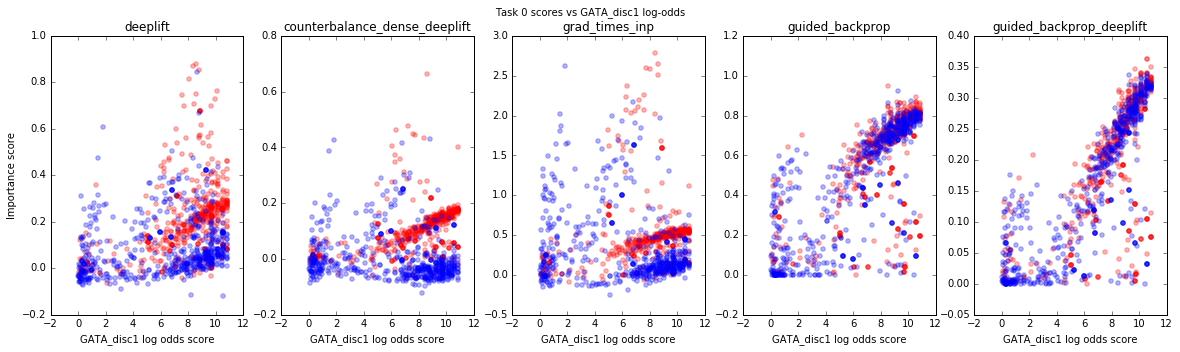

motif: TAL1_known1


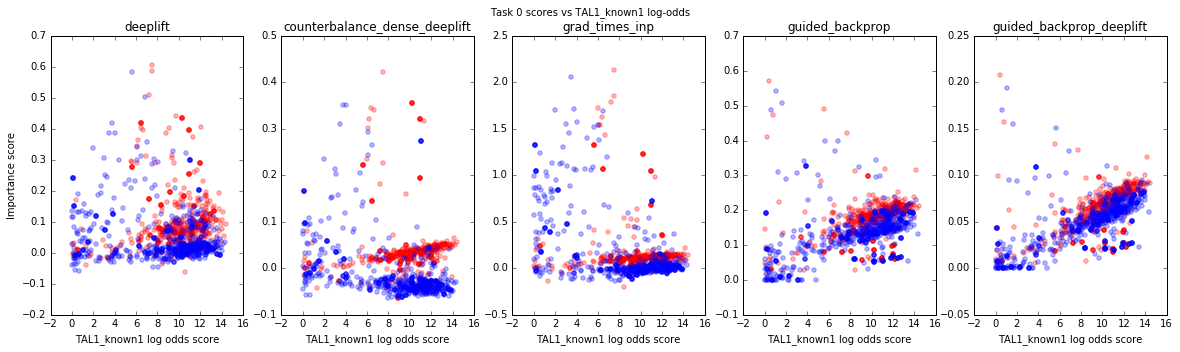

task: 1
motif: GATA_disc1


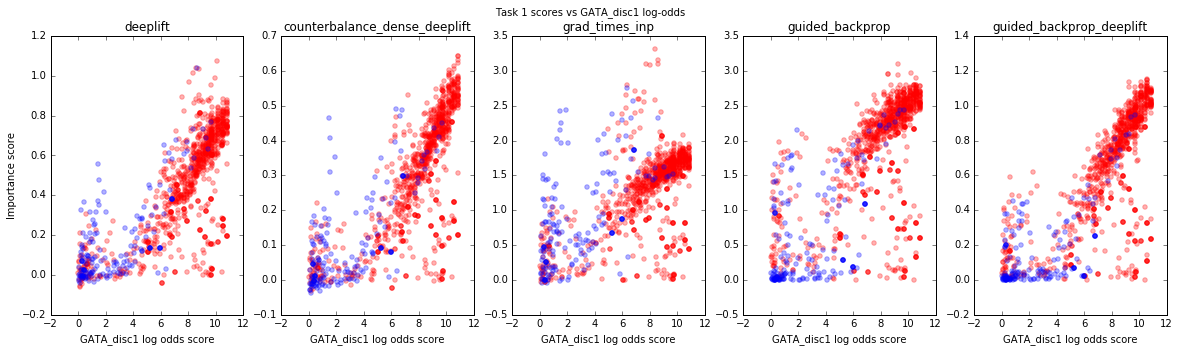

motif: TAL1_known1


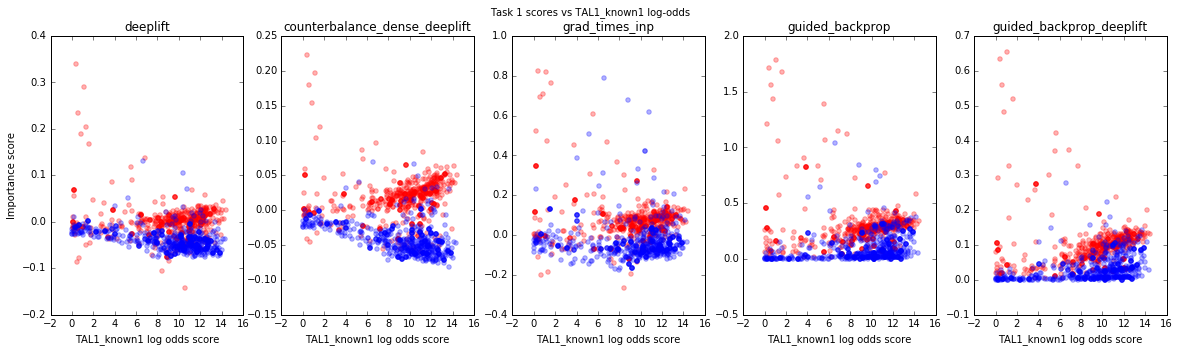

task: 2
motif: GATA_disc1


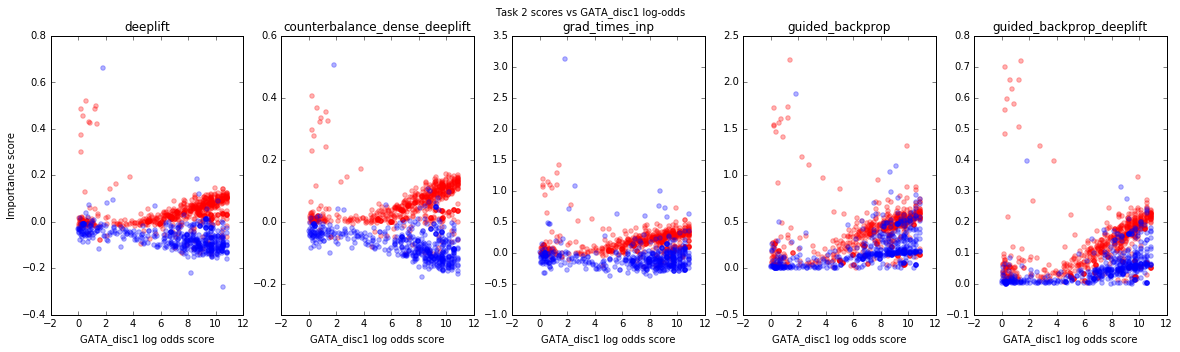

motif: TAL1_known1


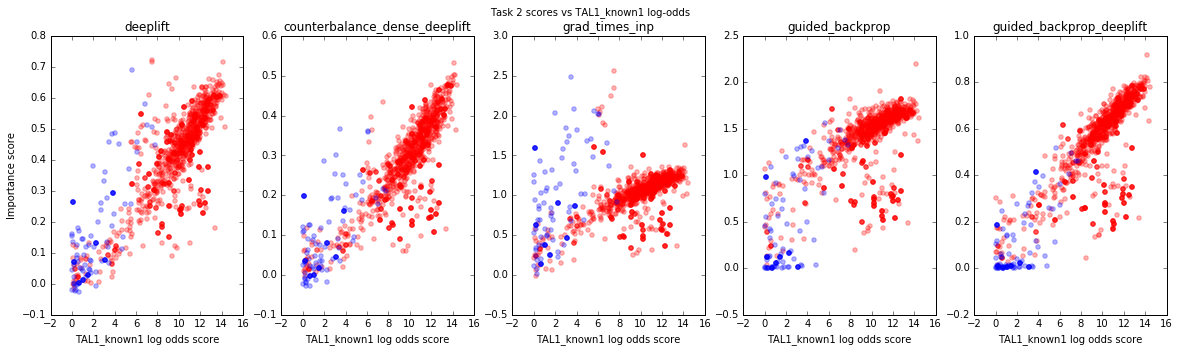

In [255]:
for task_idx in [0,1,2]:
    print("task: "+str(task_idx))
    for motif_name in ['GATA_disc1', 'TAL1_known1']:
        print("motif: "+str(motif_name))
        
        fig = plt.figure(figsize=(20,5))
        fig.suptitle("Task "+str(task_idx)+" scores vs "+motif_name+" log-odds")
        methods = ['deeplift',
                   'counterbalance_dense_deeplift',
                   'grad_times_inp',
                   'guided_backprop', 'guided_backprop_deeplift',
                   #'pos_through_dense_deeplift',
                   ]
        for method_num, method in enumerate(methods):
            ax = plt.subplot(1,len(methods),method_num+1)
            for label in [1,0]:            
                scores = method_to_task_to_scores[method][task_idx]
                log_odds_scores, averaged_scores = compare_log_odds_score_to_deeplift_scores(
                    data_onehot, scores, motif_name)

                log_odds_scores, averaged_scores =\
                    [np.array([x[0] for x in zip(arr, data.labels) if x[1][task_idx]==label])
                     for arr in [log_odds_scores, averaged_scores]]


                scatter_plot_coords =\
                 np.array([x for x in zip(log_odds_scores.ravel(), averaged_scores.ravel()) if x[0] > 0])
                ax.scatter(scatter_plot_coords[:,0],scatter_plot_coords[:,1],
                           alpha=0.3,color=("blue" if label==0 else "red"))
            if (method_num==0):
                ax.set_ylabel("Importance score")
            ax.set_xlabel(motif_name+" log odds score")
            ax.set_title(method)
        plt.show()


In [131]:
motif_locations = {0:[], 1:[], 2:[]}
for idx,embeddings in enumerate(data.embeddings):
    for task in motif_locations:
        motif_locations[task].append([])
    for embedding in embeddings:
        if ('TAL1_known1' in embedding.what.getDescription()):
            positive_tasks = [2]
            negative_tasks = [1]
        if ('GATA_disc1' in embedding.what.getDescription()):
            positive_tasks = [1]
            negative_tasks = [2]
        if (data.labels[idx][0]==1):
            positive_tasks += [0]
        else:
            negative_tasks += [0]
        for task in positive_tasks:
            motif_locations[task][-1].append((embedding.startPos, embedding.startPos+len(embedding.what),1))
        for task in negative_tasks:
            motif_locations[task][-1].append((embedding.startPos, embedding.startPos+len(embedding.what),-1))

In [132]:
def compile_scores_on_motif_locations_vs_others(scores, motif_locations,
                                                smoothen_function, batch_size=200, progress_update=None):
    scores = smoothen_function(scores, batch_size=batch_size, progress_update=progress_update)
    scores_on_valid_locations = []
    scores_on_invalid_locations = []
    scores_on_other_locations = []
    percent_on_valid = []
    percent_on_invalid = []
    percent_on_other = []
    for scores_single_region,motif_locations_single_region in zip(scores, motif_locations):
        scores_on_valid_this_region = []
        scores_on_invalid_this_region = []
        scores_on_other_this_region = []
        #sort motif locations in order
        sorted_motif_locations = sorted(motif_locations_single_region, key=lambda x: x[0])
        for i in range(len(sorted_motif_locations)):
            prev_end = 0 if i==0 else sorted_motif_locations[i-1][1]
            if (sorted_motif_locations[i][2]==1):
                array_to_add_to = scores_on_valid_this_region
            else:
                array_to_add_to = scores_on_invalid_this_region
            array_to_add_to.extend(scores_single_region[
                    sorted_motif_locations[i][0]:sorted_motif_locations[i][1]])
            scores_on_other_this_region.extend(scores_single_region[prev_end:sorted_motif_locations[i][0]])
            if (i == len(sorted_motif_locations)-1): #if last motif, take the remainder
                scores_on_other_this_region.extend(scores_single_region[sorted_motif_locations[i][1]:len(scores_single_region)])
        scores_on_valid_locations.extend(scores_on_valid_this_region)
        scores_on_invalid_locations.extend(scores_on_invalid_this_region)
        scores_on_other_locations.extend(scores_on_other_this_region)
        total_on_valid, total_on_invalid, total_on_other = [np.sum(np.array(scores_this_region)*(np.array(scores_this_region)>0))
                                                            for scores_this_region in
                                                                scores_on_valid_this_region,
                                                                scores_on_invalid_this_region,
                                                                scores_on_other_this_region]
        total_scores = total_on_valid + total_on_invalid + total_on_other
        percent_on_valid.append(total_on_valid/(total_scores+1E-7))
        percent_on_invalid.append(total_on_invalid/(total_scores+1E-7))
        percent_on_other.append(total_on_other/(total_scores+1E-7))
        
    return scores_on_valid_locations, scores_on_invalid_locations, scores_on_other_locations,\
           np.array(percent_on_valid), np.array(percent_on_invalid), np.array(percent_on_other)

Task 0
deeplift
0.262590576646
0.598463833873
(0.23210951496479729, 0.28153602256931537, 0.22260444116046163)


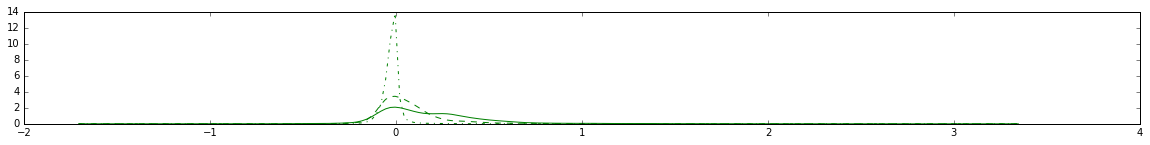

grad_times_inp
0.299912327451
0.573298933983
(0.21739580015855645, 0.15171802993418762, 0.3671361602154567)


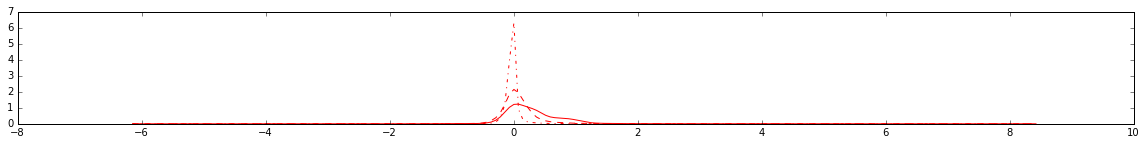

guided_backprop
0.117731005559
0.723992632546
(0.19193224929720704, 0.29484710059831054, 0.24822064190712476)


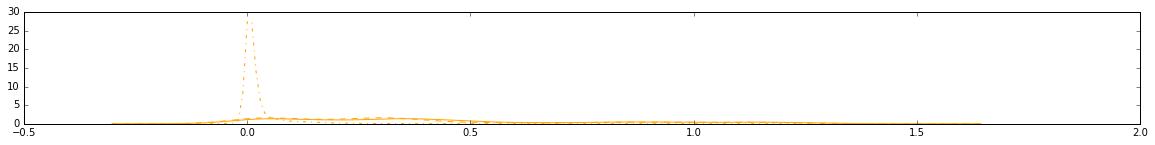

counterbalance_dense_deeplift
0.477111374604
0.578203229068
(0.22312823018408728, 0.097691989837585883, 0.41542967979846523)


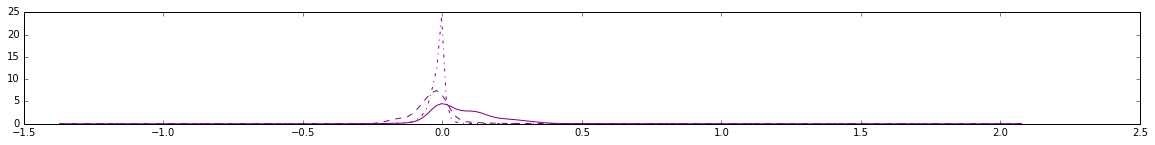

Task 1
deeplift
0.663564358982
0.706926200299
(0.40839965010601098, 0.051430958925759905, 0.27641935762695047)


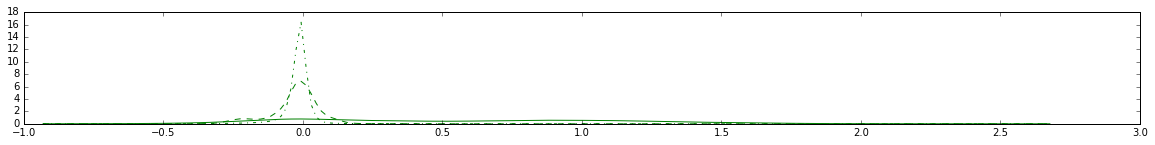

grad_times_inp
0.684518231074
0.739999850696
(0.37989992063115052, 0.063751541777002818, 0.2925985297346414)


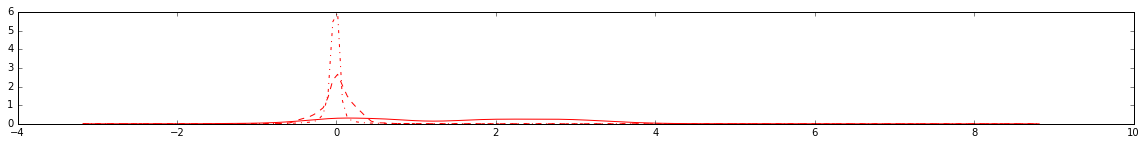

guided_backprop
0.768498105848
0.851502632997
(0.30508689628686997, 0.14099711712384985, 0.29016585967419462)


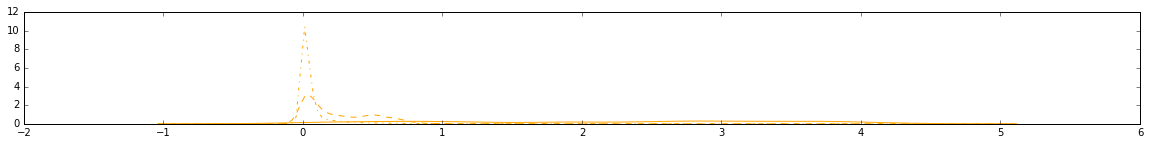

counterbalance_dense_deeplift
0.624724136658
0.704408532616
(0.37906757777810396, 0.064064062804700339, 0.29311830502587033)


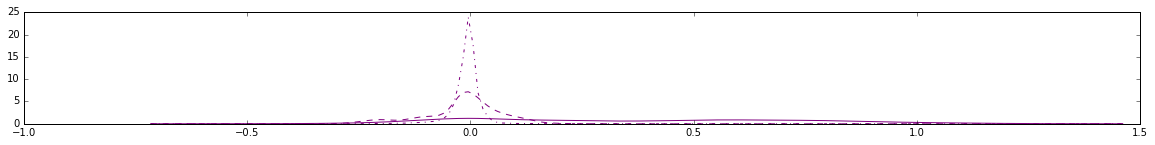

Task 2
deeplift
0.561265855513
0.618989232399
(0.40931935719266188, 0.039875992537808769, 0.28705462294838779)


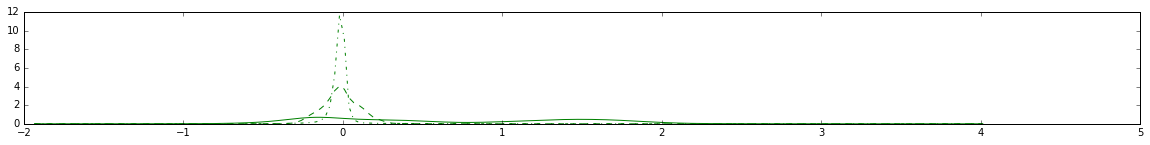

grad_times_inp
0.525361956589
0.605728895165
(0.37729953250046194, 0.059456879609394664, 0.29949358227070105)


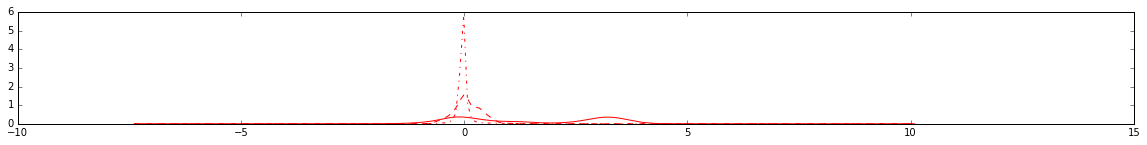

guided_backprop
0.609679423121
0.741304676421
(0.31072523059702872, 0.1560832207151101, 0.26944154252894709)


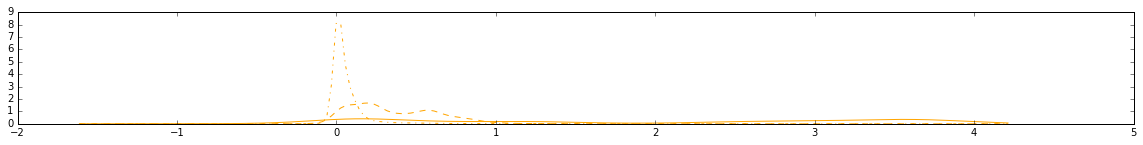

counterbalance_dense_deeplift
0.513359527372
0.619820591137
(0.37545046722172942, 0.053484508733353892, 0.30731497508696326)


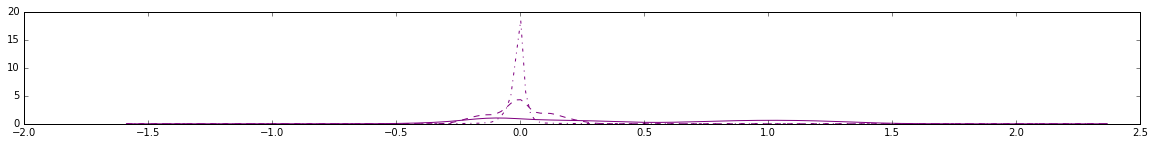

In [133]:
import matplotlib.pyplot as plt
import scipy
import deeplift.util
reload(deeplift.util)
smoothen_window = 1
smoothen_function = deeplift.util.get_smoothen_function(smoothen_window)
for task_idx in motif_locations:    
    print("Task "+str(task_idx))
    for method,color in [('deeplift','green'),
                         ('grad_times_inp','red'),
                         ('guided_backprop','orange'),
                         ('counterbalance_dense_deeplift','purple'),]:
        scores_on_valid_locations, scores_on_invalid_locations, scores_on_other_locations,\
         percent_on_valid, percent_on_invalid, percent_on_other =\
            compile_scores_on_motif_locations_vs_others(
                method_to_task_to_scores[method][task_idx],
                motif_locations[task_idx], smoothen_function=smoothen_function)
        from scipy.stats import gaussian_kde
        min_val = min(np.min(scores_on_invalid_locations), np.min(scores_on_valid_locations))
        max_val = max(np.max(scores_on_invalid_locations), np.max(scores_on_valid_locations))
        negative_density = gaussian_kde(scores_on_invalid_locations)
        neutral_density = gaussian_kde(scores_on_other_locations)
        positive_density = gaussian_kde(scores_on_valid_locations)
        import matplotlib.pyplot as plt
        plt.figure(figsize=(20,2))
        xs = np.linspace(min_val, max_val,200)
        plt.plot(xs,negative_density(xs),ls='dashed',color=color)
        plt.plot(xs,neutral_density(xs),ls='dashdot',color=color)
        plt.plot(xs,positive_density(xs),ls='solid',color=color)
        print(method)
        print(str(scipy.stats.ks_2samp(scores_on_invalid_locations, scores_on_valid_locations).statistic))
        print(str(scipy.stats.ks_2samp(scores_on_other_locations, scores_on_valid_locations).statistic))
        print(np.mean(percent_on_valid), np.mean(percent_on_invalid), np.mean(percent_on_other))
        plt.show()

Visualize the scores at the sequences predicted most confidently. Cyan boxes indicate the ground-truth locations of the inserted TAL1_known1 motifs, red boxes indicate the ground-truth locations of the inserted GATA_disc1 motifs

Sorted by task 0
confidence: [ 0.97473156  0.99927729  1.        ]
Scores for task: 0
5.71981
deeplift


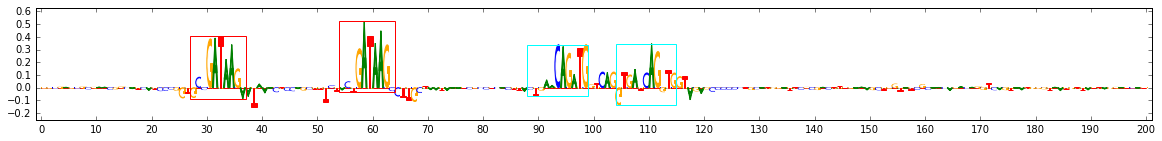

14.4757
grad_times_inp


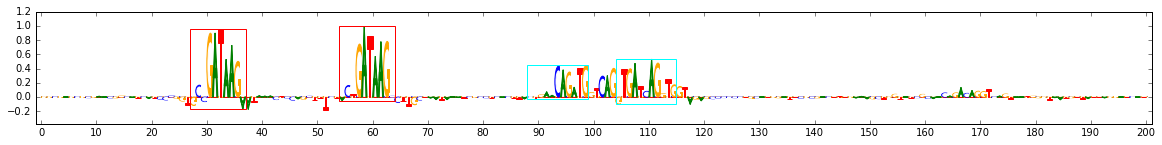

26.9929
guided_backprop


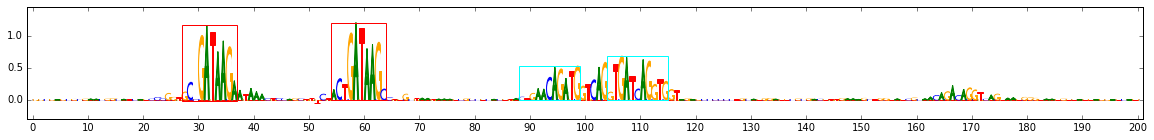

3.57526
counterbalance_dense_deeplift


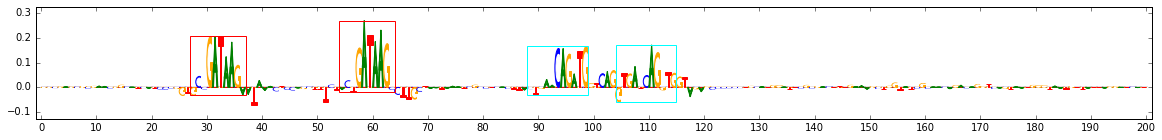

Scores for task: 1
8.22009
deeplift


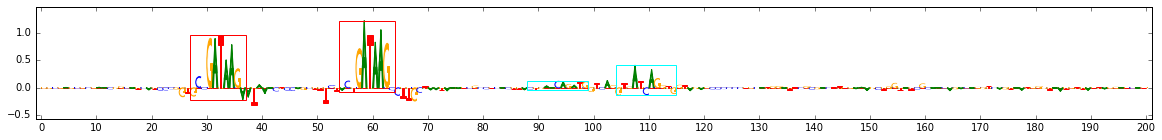

33.1801
grad_times_inp


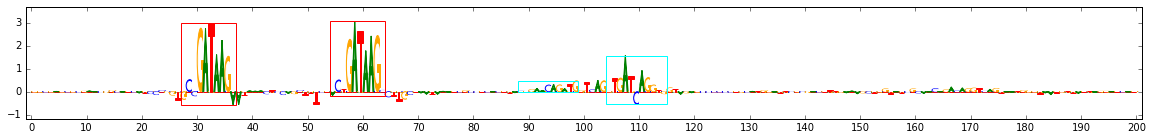

72.8218
guided_backprop


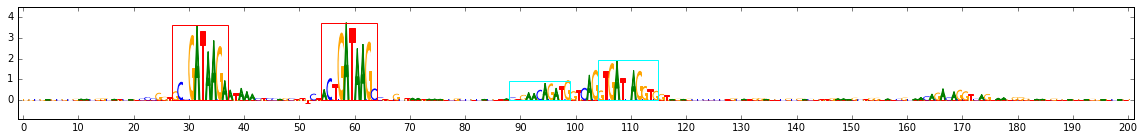

7.30185
counterbalance_dense_deeplift


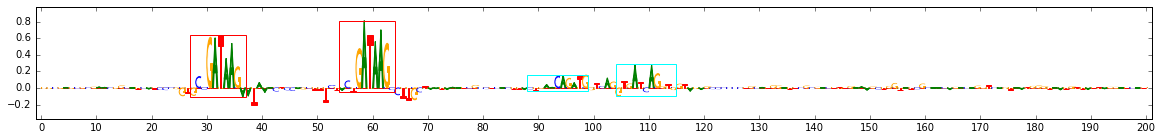

Scores for task: 2
16.3251
deeplift


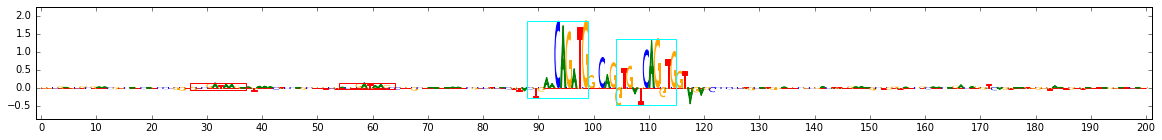

46.8682
grad_times_inp


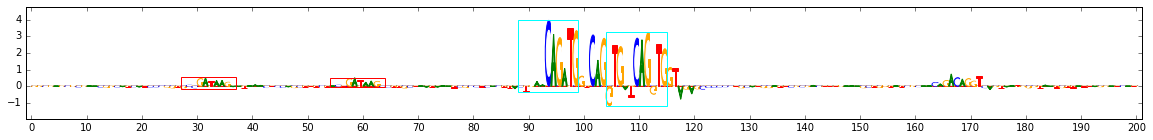

82.1051
guided_backprop


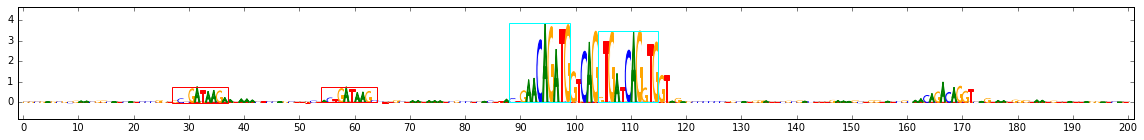

14.8623
counterbalance_dense_deeplift


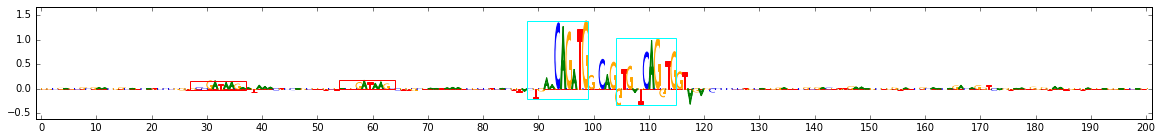

Sorted by task 1
confidence: [ 0.0018154   0.99832803  0.00158168]
Scores for task: 0
-4.24242
deeplift


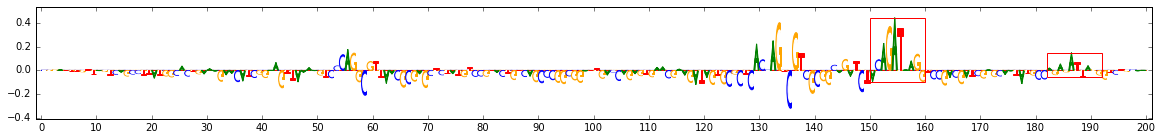

7.49513
grad_times_inp


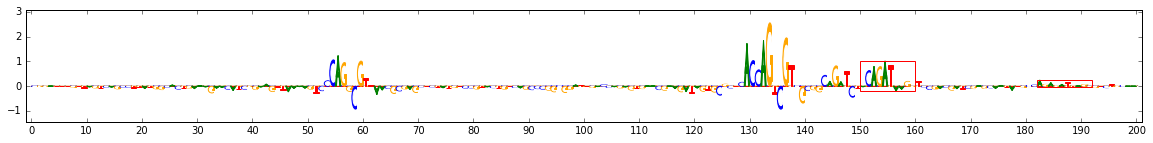

16.2397
guided_backprop


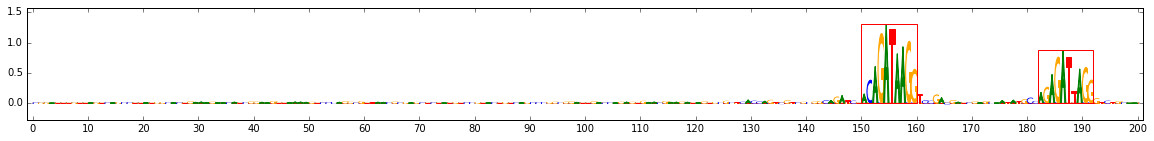

-5.29755
counterbalance_dense_deeplift


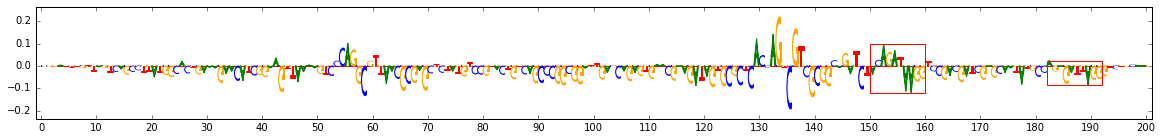

Scores for task: 1
7.38036
deeplift


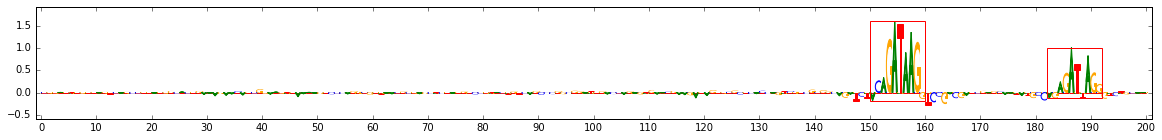

20.0011
grad_times_inp


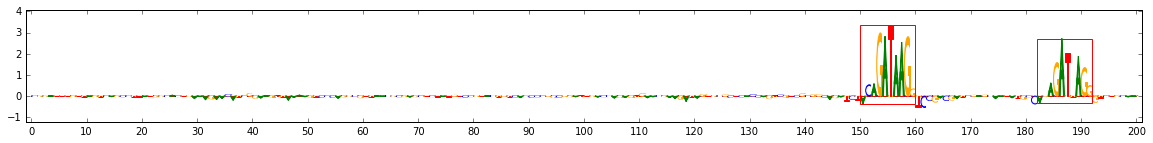

55.6142
guided_backprop


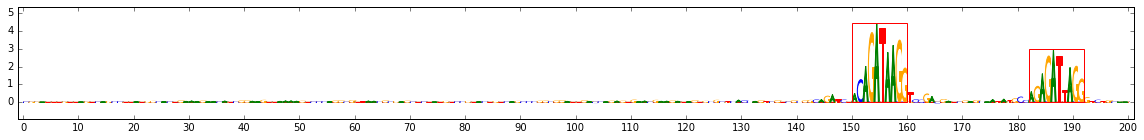

6.44641
counterbalance_dense_deeplift


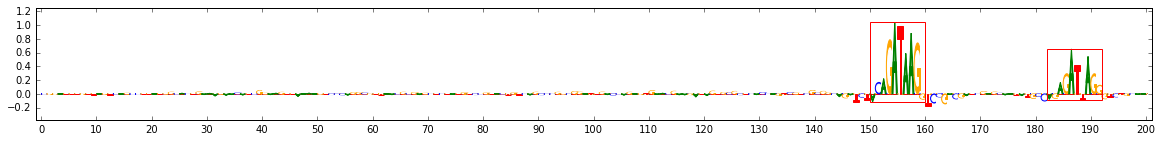

Scores for task: 2
-5.40131
deeplift


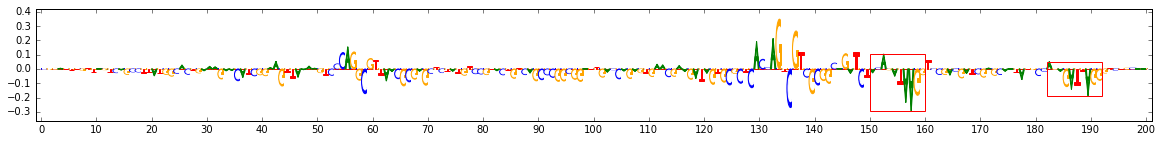

3.48451
grad_times_inp


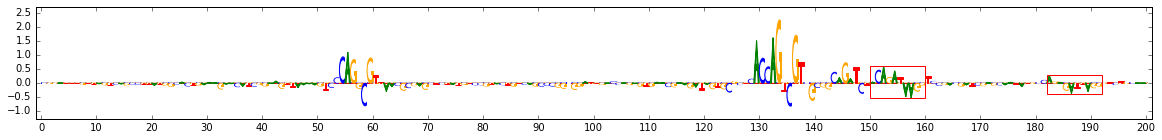

6.86047
guided_backprop


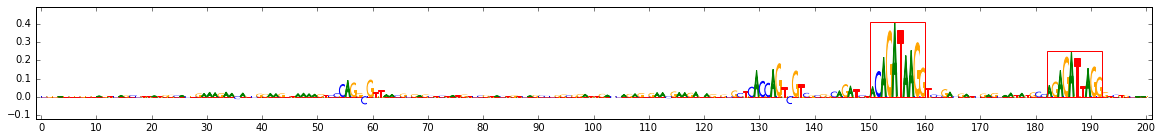

-5.53564
counterbalance_dense_deeplift


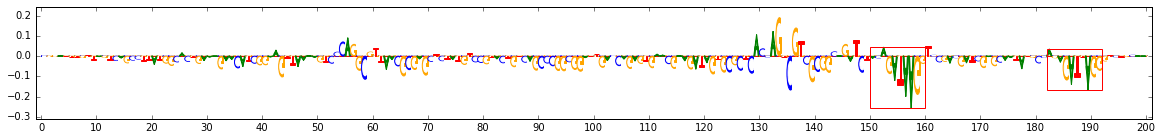

Sorted by task 2
confidence: [ 0.00904571  0.00661924  1.        ]
Scores for task: 0
-2.62917
deeplift


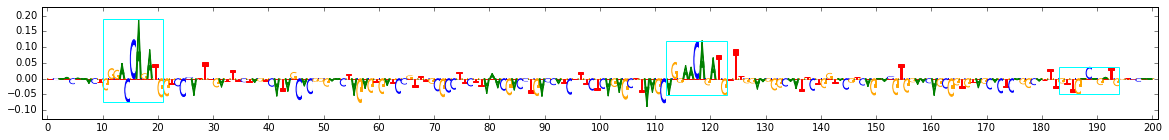

-4.61115
grad_times_inp


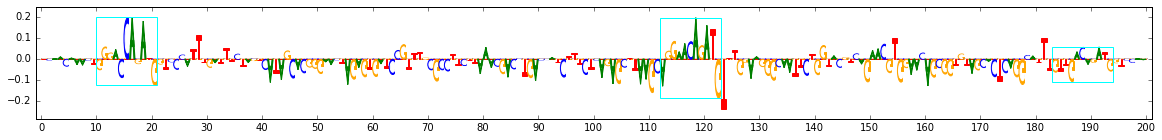

8.47428
guided_backprop


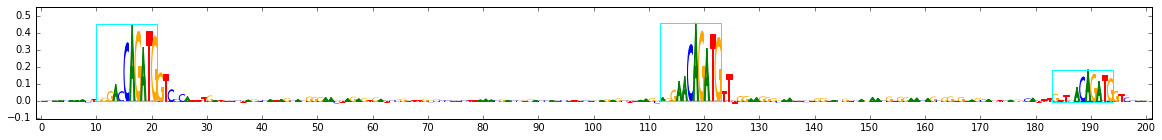

-3.99611
counterbalance_dense_deeplift


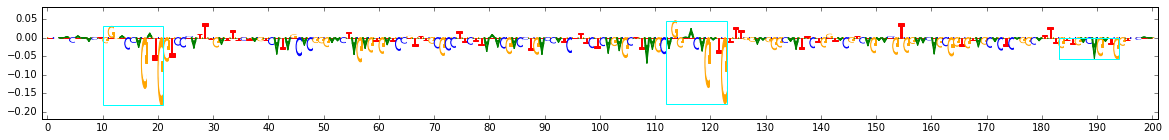

Scores for task: 1
-4.02283
deeplift


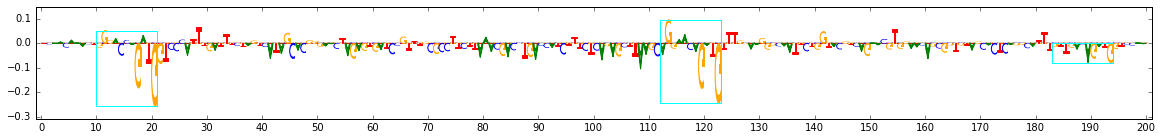

-6.34326
grad_times_inp


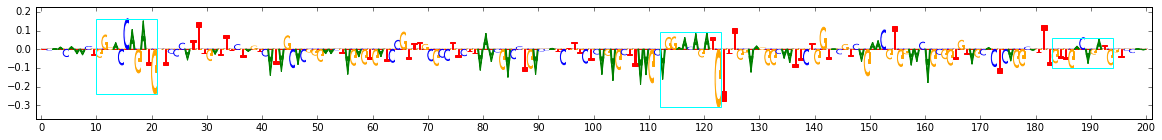

13.4793
guided_backprop


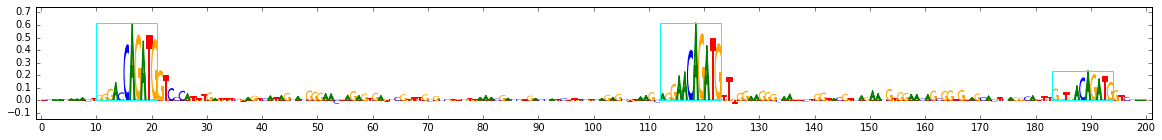

-4.17921
counterbalance_dense_deeplift


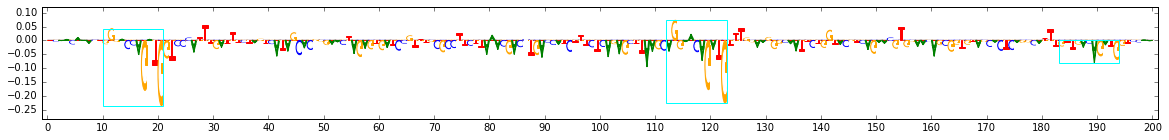

Scores for task: 2
17.883
deeplift


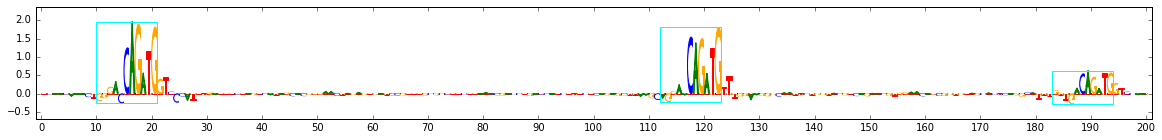

39.905
grad_times_inp


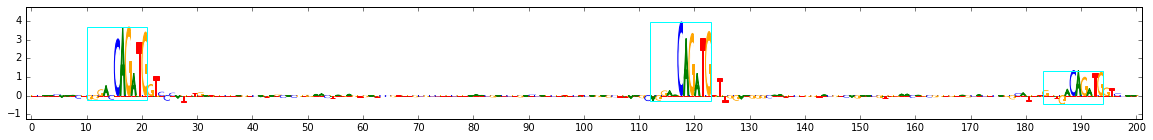

69.9426
guided_backprop


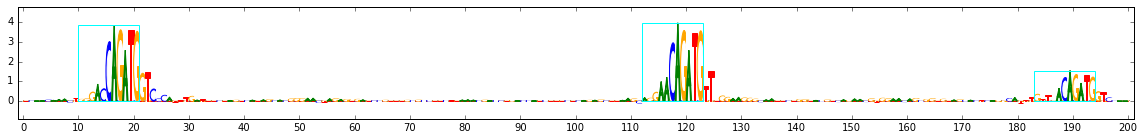

16.3491
counterbalance_dense_deeplift


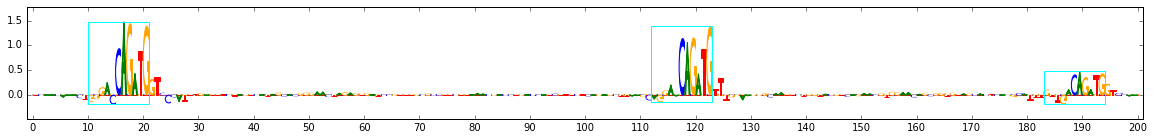

In [134]:
#visualize scores + ground-truth locations of motifs
%matplotlib inline
from deeplift.visualization import viz_sequence

sorted_predictions_by_task = [
    sorted(enumerate(predictions), key=lambda x: -x[1][0]),
    sorted(enumerate(predictions), key=lambda x: -(x[1][1]-x[1][2])),
    sorted(enumerate(predictions), key=lambda x: -(x[1][2]-x[1][1]))]

for sort_task in [0,1,2]:
    print("Sorted by task "+str(sort_task))
    sorted_idx = 55
    idx = sorted_predictions_by_task[sort_task][sorted_idx][0]
    conf = sorted_predictions_by_task[sort_task][sorted_idx][1]
    print("confidence: "+str(conf))
    for task in [0,1,2]:
        print("Scores for task: "+str(task))
        for method_name in ['deeplift', 'grad_times_inp', 'guided_backprop', 'counterbalance_dense_deeplift']:
            scores = method_to_task_to_scores[method_name][task]
            scores_for_idx = scores[idx]
            print(np.sum(scores_for_idx))
            original_onehot = data_onehot[idx]
            scores_for_idx = original_onehot*scores_for_idx[None,None,:]
            print(method_name)
            highlight = {'red':[(start,end) for start,end,valid in motif_locations[1][idx] if valid==1],
                         'cyan':[(start,end) for start,end,valid in motif_locations[2][idx] if valid==1]}
            viz_sequence.plot_weights(scores_for_idx, subticks_frequency=10, highlight=highlight)

Compute DeepLIFT scores on the channels

In [87]:
#Import some general util stuff
import sys, os
scriptsDir = os.environ.get("UTIL_SCRIPTS_DIR");
if (scriptsDir is None):
    raise Exception("Please set environment variable UTIL_SCRIPTS_DIR to point to av_scripts");
sys.path.insert(0,scriptsDir);
import pathSetter;
import util;
import fileProcessing as fp
from plottingUtilitiesPackage import matplotlibHelpers as mplh;

#import deepLIFT stuff
scriptsDir = os.environ.get("ENHANCER_SCRIPTS_DIR");
if (scriptsDir is None):
    raise Exception("Please set environment variable ENHANCER_SCRIPTS_DIR to point to enhancer_prediction_code");
sys.path.insert(0,scriptsDir+"/featureSelector/deepLIFFT/");
import criticalSubsetIdentification as csi
import deepLIFTutils

In [88]:
task_idx=0
sequence_data_on_positives = np.array([data_onehot[i] for i in range(len(data.labels)) if data.labels[i][task_idx]==1])

In [89]:
model_to_use = deeplift_model

In [90]:
#compute scores of the channels
#computing deeplift scores on the conv layers
conv_layer_deeplift_contribs_func = model_to_use.get_target_contribs_func(
    find_scores_layer_name='conv1',
    pre_activation_target_layer_name="output_preact")
filter_contribs = np.array(conv_layer_deeplift_contribs_func(task_idx=task_idx,
        input_data_list=[sequence_data_on_positives],
        batch_size=200, progress_update=1000))
filter_contribs_revcomp = np.array(conv_layer_deeplift_contribs_func(task_idx=task_idx,
        input_data_list=[sequence_data_on_positives[:,:,::-1,::-1]],
        batch_size=200, progress_update=1000))

Done 0
Done 0


Visualize the top-scoring channels

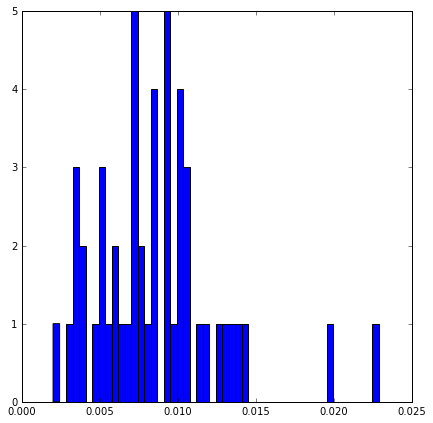

In [91]:
per_channel_scores = np.mean(np.squeeze(np.abs(filter_contribs))
                             +np.squeeze(np.abs(filter_contribs_revcomp)),axis=(-1,0))
#plot a histogram
from plottingUtilitiesPackage import matplotlibHelpers as mplh
reload(mplh)
mplh.plotHist(per_channel_scores,bins=50)

importance: 0.0228596 bias: -0.504632


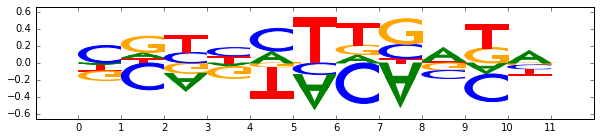

importance: 0.0197189 bias: -2.36772


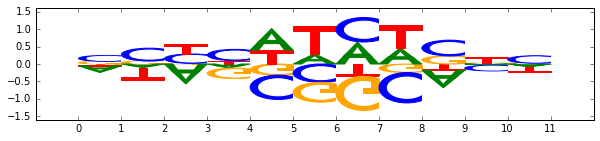

importance: 0.0142614 bias: -0.492065


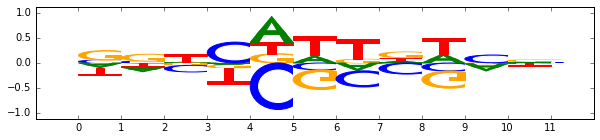

importance: 0.0140549 bias: -0.238519


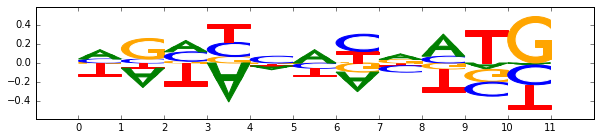

importance: 0.0134804 bias: -0.520951


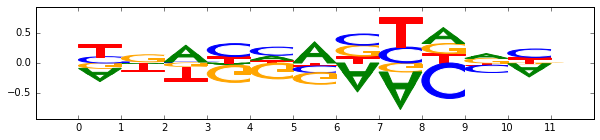

In [92]:
filter_weights, filter_biases = model_to_use.get_name_to_blob()['conv1'].W,\
                                model_to_use.get_name_to_blob()['conv1'].b

#sort filters by bias, plot weights
from deeplift.visualization import viz_sequence
filters_sorted_by_importance = sorted(zip(filter_weights, filter_biases, per_channel_scores), key=lambda x: -x[2])

for i in range(0,5):
    this_filter_bias = filters_sorted_by_importance[i][1]
    this_filter_weights = filters_sorted_by_importance[i][0]
    this_filter_importance = filters_sorted_by_importance[i][2]
    print("importance: "+str(this_filter_importance)+" bias: "+str(this_filter_bias))
    viz_sequence.plot_weights(np.squeeze(this_filter_weights), figsize=(10,2))

Compute the DeepLIFT scores and multipliers on the sequence

In [93]:
sequence_deeplift_contribs_func = model_to_use.get_target_contribs_func(
    find_scores_layer_name='sequence',
    pre_activation_target_layer_name='output_preact')
sequence_contribs = np.array(
                        sequence_deeplift_contribs_func(task_idx=task_idx,
                            input_data_list=[sequence_data_on_positives],
                            batch_size=200, progress_update=1000))
sequence_contribs = np.sum(sequence_contribs,axis=-2)[:,:,None,:]*sequence_data_on_positives

#computing multipliers on sequence
sequence_deeplift_multipliers_func = model_to_use.get_target_multipliers_func(
                                        find_scores_layer_name='sequence',
                                        pre_activation_target_layer_name='output_preact')
sequence_multipliers = np.array(sequence_deeplift_multipliers_func(task_idx=task_idx,
        input_data_list=[sequence_data_on_positives],
        batch_size=200, progress_update=1000))

Done 0
Done 0


Identify high-scoring segments

In [94]:
#identify the seqlets
reload(csi)
segmentIdentifier = csi.FixedWindowAroundPeaks(
                        slidingWindowForMaxSize=7,
                        flankToExpandAroundPeakSize=3,
                        excludePeaksWithinWindow=7,
                        ratioToTopPeakToInclude=0.3,
                        maxSegments=4)

seqlets, seqletIndices = csi.getSeqlets(
                                rawDeepLIFTContribs=sequence_contribs,
                                indicesToGetSeqletsOn=None,
                                revCompFunc=csi.dnaRevCompFunc,
                                outputsBeforeActivation=None, #don't worry about this
                                activation=None, #don't worry about this
                                thresholdProb=1.0, #don't worry about this
                                segmentIdentifier=segmentIdentifier,
                                numThreads=1,
                                secondsBetweenUpdates=1)

#filter out any shorter seqlets from the edges of sequences
maxSeqletLength = np.max([x.numUnderlyingObservations.shape[-1] for x in seqlets])
seqlets = [x for x in seqlets if x.numUnderlyingObservations.shape[-1] == maxSeqletLength]
seqlets_subset = seqlets[:]

Done 0 of 208
Done 100 of 208
Done 200 of 208


In [95]:
reload(csi)
import deeplift.util as deeplift_util
reload(deeplift_util)

#augment tracks
for (dataToAugmentWith,
     name,
     pseudocount,
     fullRevCompDataArr,
     revCompFunc,
     effectiveWidth,
     effectiveStride,
     layerFromAbove) in [
       (
            #note: multiplication by 1.0 is necessary to prevent integer overflow due to int8 or whatever
            np.squeeze(sequence_data_on_positives, axis=1)*1.0, #data (raw sequence here)
            "sequence", #name
             0.25, #pseudocount
             None, #fullRevCompDataArr
             csi.dnaRevCompFunc, #revCompFunc
             1, #effectiveWidth
             1, #effectiveStride
             False #layerFromAbove
        ),
       (
            np.squeeze(sequence_multipliers, axis=1), #data
            "sequence_multipliers", #name
            0.0, #pseudocount
            None, #fullRevCompDataArr
            csi.dnaRevCompFunc, #revCompFunc
            1, #effectiveWidth
            1, #effectiveStride
            False #layerFromAbove
        ),
        (
            np.squeeze(sequence_contribs, axis=1), #data
            "sequence_deeplift", #name
            0.0, #pseudocount
            None, #fullRevCompDataArr
            csi.dnaRevCompFunc, #revCompFunc
            1, #effectiveWidth
            1, #effectiveStride
            False #layerFromAbove
        ),
        (
            np.squeeze(filter_contribs, axis=2), #data
            "filter_deeplift", #name
            0.0, #pseudocount
            np.squeeze(filter_contribs_revcomp, axis=2), #fullRevCompDataArr
            None, #revCompFunc
            filter_weights.shape[-1], #effectiveWidth
            1, #effectiveStride
            True #layerFromAbove
        )
]:
    csi.augmentSeqletsWithData(
        seqlets_subset,
        fullDataArr=dataToAugmentWith,
        keyName=name,
        pseudocount=pseudocount,
        fullRevCompDataArr=fullRevCompDataArr,
        revCompFunc=revCompFunc,
        indicesToSubset=None,
        effectiveStride=effectiveStride,
        effectiveWidth=effectiveWidth,
        layerFromAbove=layerFromAbove,
        fillValue=0)

('idx', 0)
85


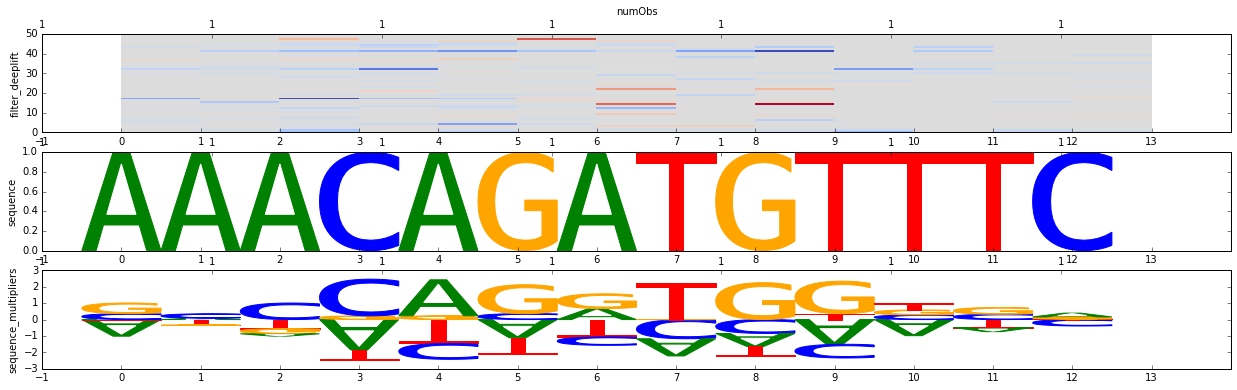

('idx', 0, 'reverse')


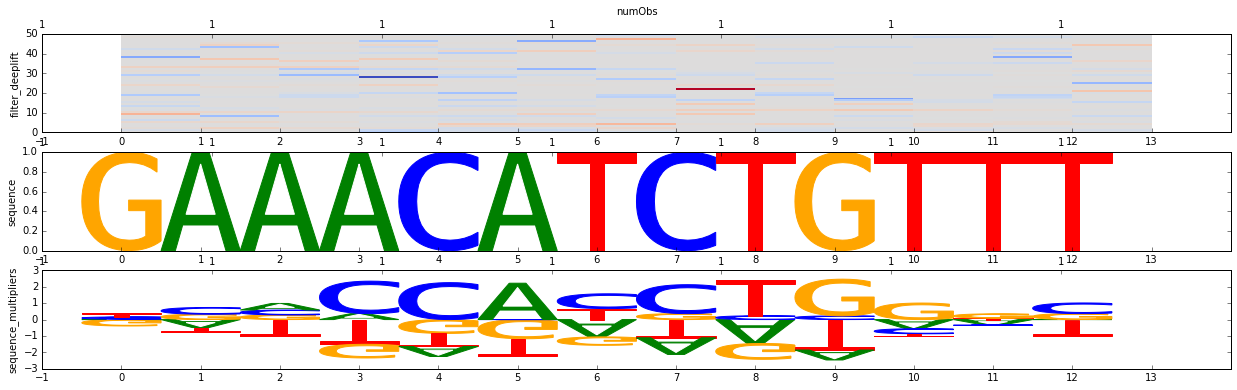

('idx', 1)
181


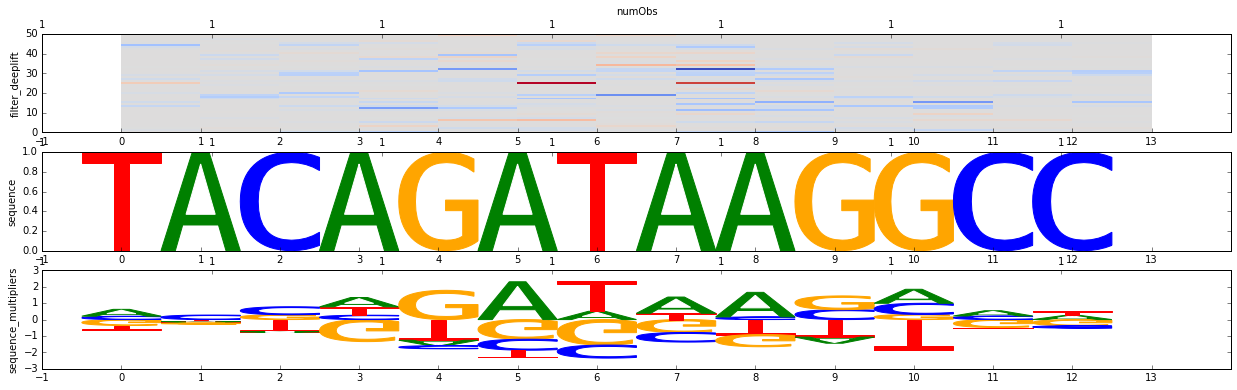

('idx', 1, 'reverse')


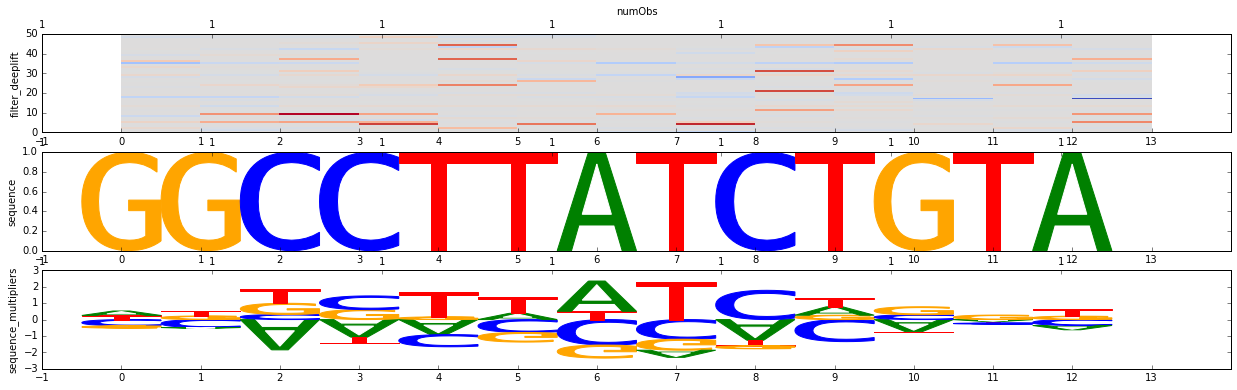

('idx', 2)
111


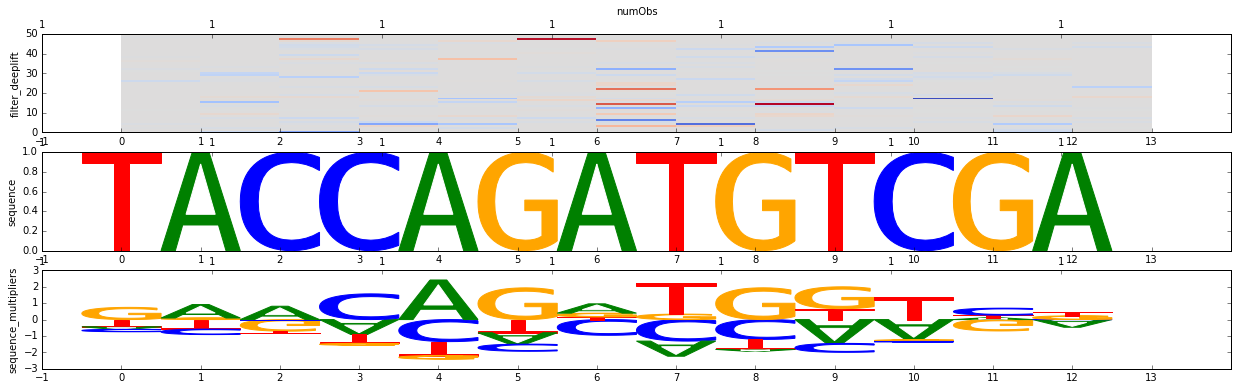

('idx', 2, 'reverse')


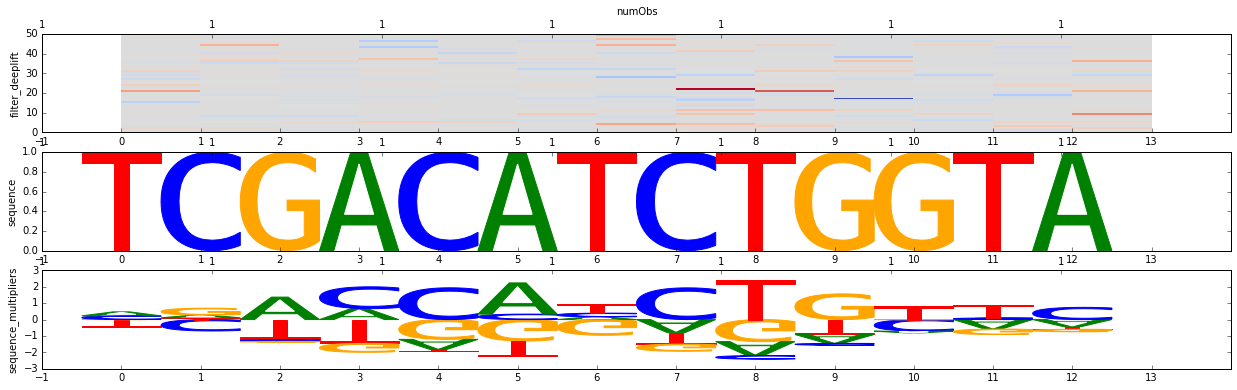

In [96]:
#visually explore some seqlets as a sanity check
reload(csi)
trackNamesToPrint=["filter_deeplift", "sequence", "sequence_multipliers"]
for idx in range(0,3):
    print("idx",idx)
    print(seqlets[idx].sequenceId)
    csi.printGrammar(seqlets[idx], trackNamesToPrint=trackNamesToPrint, heightPerTrack=2);
    print("idx",idx,"reverse")
    csi.printGrammar(seqlets[idx].getRevCompGrammar(), trackNamesToPrint=trackNamesToPrint, heightPerTrack=2)

In [97]:
reload(util)
reload(csi)
seqlets_corr_mat = csi.getCorrelationMatrix(
                        seqlets_subset,
                        subtracksToInclude=["filter_deeplift"],
                        accountForRevComp=True,
                        numThreads=None,
                        secondsBetweenUpdates=3,
                        xcorBatchSize=50)

Num words: 441 and 441
('On filters', 0, 'to', 1538)
Done 0
('On filters', 0, 'to', 1538)
Done 0
Seconds to compute corr mat: 1.10461807251


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 441 / 441
[t-SNE] Mean sigma: 0.136734
[t-SNE] Iteration 25: error = 0.7915603, gradient norm = 0.0213961
[t-SNE] Iteration 50: error = 0.8370551, gradient norm = 0.0192268
[t-SNE] Iteration 75: error = 0.6212670, gradient norm = 0.0159830
[t-SNE] Iteration 100: error = 0.6883430, gradient norm = 0.0145070
[t-SNE] Error after 100 iterations with early exaggeration: 0.688343
[t-SNE] Iteration 125: error = 0.5631322, gradient norm = 0.0132076
[t-SNE] Iteration 150: error = 0.6441950, gradient norm = 0.0139878
[t-SNE] Iteration 175: error = 0.6804400, gradient norm = 0.0135225
[t-SNE] Iteration 175: did not make any progress during the last 30 episodes. Finished.
[t-SNE] Error after 175 iterations: 0.680440


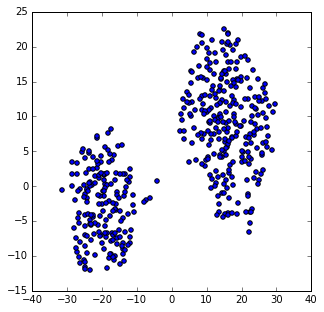

In [98]:
#find the t-sne embedding using the distance metric
reload(csi)
np.random.seed(1234)
embedding_corr = csi.getTsneEmbeddingOfGrammars(seqlets_corr_mat, perplexity=50, verbose=2)
mplh.scatterPlot(embedding_corr)

In [99]:
import sklearn.cluster
kmeans_clusters = sklearn.cluster.KMeans(n_clusters=2, n_init=10).fit_predict(embedding_corr)

No colors supplied, so autogen'd as:
(0, [0.0, 1.0, 0.0])
(1, [0.0, 0.0, 1.0])


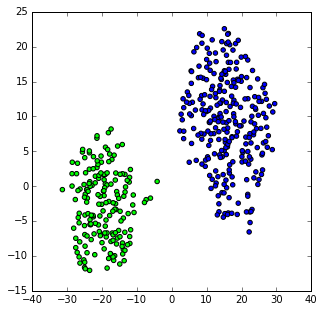

In [100]:
mplh.scatterPlot(embedding_corr, labels=kmeans_clusters)

In [101]:
merged_motifs = csi.createMergedGrammars(kmeans_clusters, seqlets
                                          , subtracksToInclude=["sequence_multipliers"]
                                          , accountForRevComp=True)
trimming_func = csi.TrimArrayColumnsToNumUnderlyingObs(0.5)
merged_motifs = csi.adjustGrammarsUsingTrimmingCriterion(merged_motifs,trimmingFunc=trimming_func)

('fwd motif', 0)


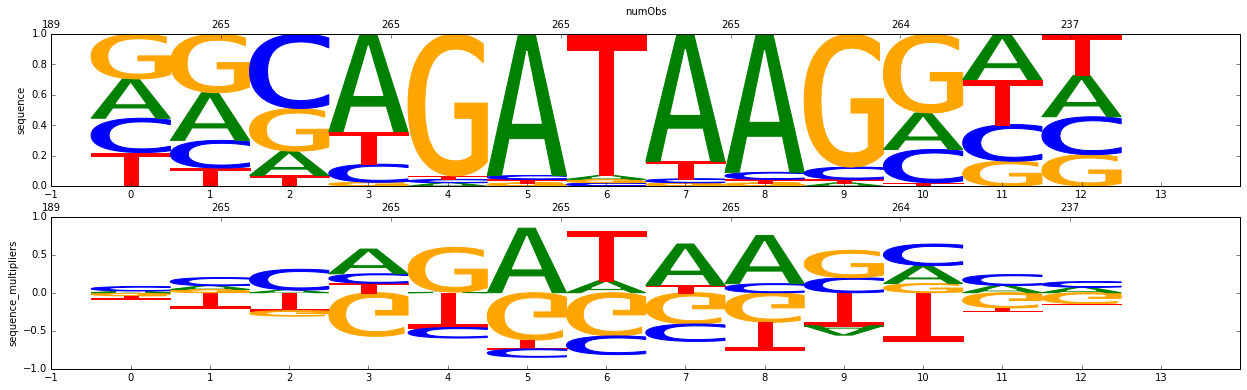

('rev motif', 0)


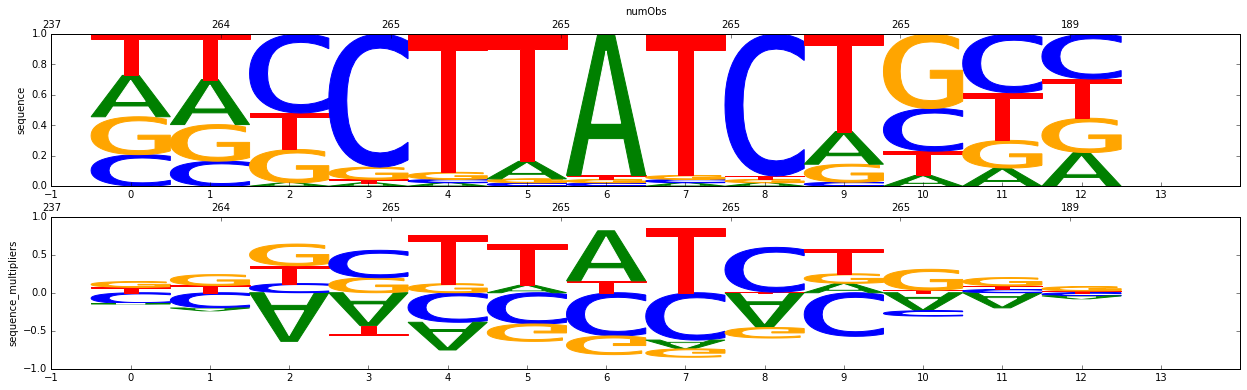

('fwd motif', 1)


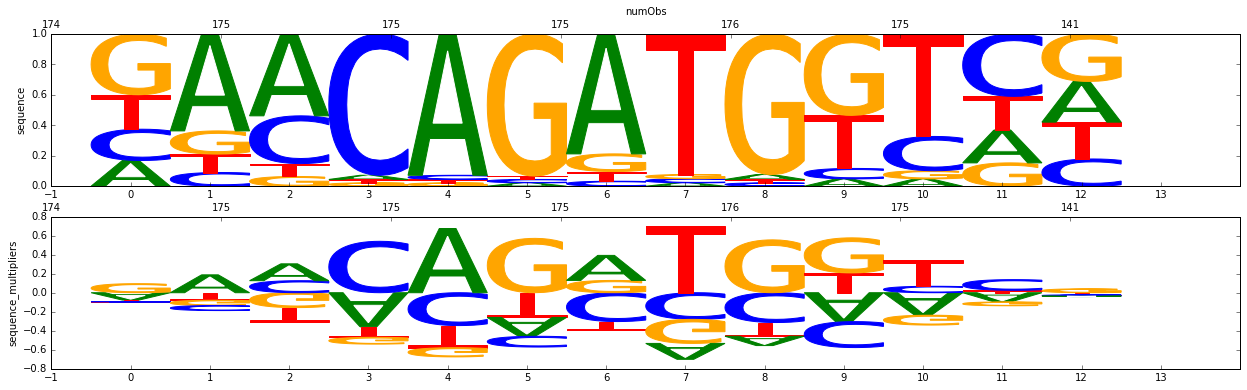

('rev motif', 1)


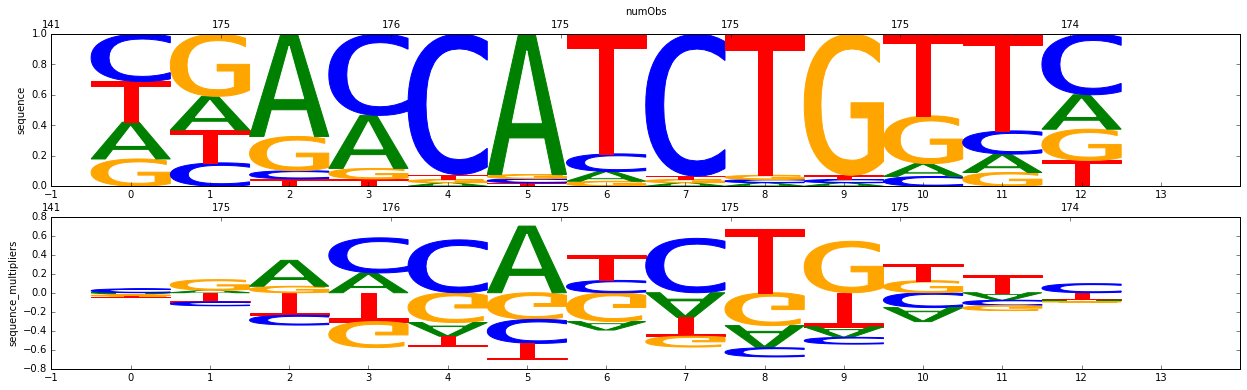

In [102]:
for idx, motif  in enumerate(sorted(merged_motifs.values(), key=lambda x: -x.totalObservationsEver)):
    print("fwd motif",idx)
    csi.printGrammar(motif, trackNamesToPrint=["sequence",
                                                 "sequence_multipliers"])
    print("rev motif",idx)
    csi.printGrammar(motif.getRevCompGrammar(), trackNamesToPrint=["sequence",
                                                 "sequence_multipliers"])